# Test Map

In [39]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# Import de tracklib

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [40]:
import matplotlib.pyplot as plt

# On charge les données
from tracklib.core.ObsTime import ObsTime
from tracklib.io.TrackReader import TrackReader
from tracklib.io.NetworkReader import NetworkReader
from tracklib.core.SpatialIndex import SpatialIndex
import tracklib.algo.Mapping as mapping


ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")

path = '/home/marie-dominique/tracklib/tracklib/data/gpx/utgtrack-22245_light.gpx'
netpath = '/home/marie-dominique/tracklib/tracklib/data/network/network_22245_light_2154.csv'

# ================================================================

tracks = TrackReader.readFromGpx(path, srid='ENU')
trace = tracks.getTrack(0)
trace.summary()

-------------------------------------
GPS track #utgtrack-22245_light of user 0:
-------------------------------------
  Nb of pt(s):   59
  Ref sys id   : ENU
  Starting at  : 12/07/2019 16:44:50
  Ending at    : 12/07/2019 16:49:59
  Duration     : 309.000 s
  Length       : 1696.944 m
-------------------------------------



In [41]:
network = NetworkReader.readFromFile(netpath, formatfile = 'TEST3')
print ('nb edges=', len(network.EDGES))
print ('nb nodes=', len(network.NODES))

100% (171 of 171) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Loading network...
nb edges= 170
nb nodes= 145


In [42]:
import json
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:2154", "epsg:4326")

x = trace.getObs(0).position.getX()
y = trace.getObs(0).position.getY()

latlong_coordinates_origin = transformer.transform(x, y)
y = latlong_coordinates_origin[0]
x = latlong_coordinates_origin[1]


out_str1 = '{ '
out_str1 += '    "type": "FeatureCollection", '
out_str1 += '    "features": [ '
        
for i in range(trace.size()):
    x = trace.getObs(i).position.getX()
    y = trace.getObs(i).position.getY()
    latlong_coordinates_origin = transformer.transform(x, y)
    x = latlong_coordinates_origin[1]
    y = latlong_coordinates_origin[0]

    x = "{:15.12f}".format(x)
    y = "{:15.12f}".format(y)
    out_str1 += '{ '
    out_str1 += '    "type": "Feature", '
    out_str1 += '    "geometry": { '
    out_str1 += '        "type": "Point", '
    out_str1 += '        "coordinates": [' + x + ', ' + y + '] '
    out_str1 += '    }, '
    out_str1 += '    "properties": { '
    out_str1 += '        "prop0": "value0" '
    out_str1 += '    } '
    out_str1 += '}'
    
    if i >= (trace.size()-1):
        break
    else:
        out_str1 += ','
            
out_str1 += '    ]'
out_str1 += '}'

#print(type(out_str), out_str)
out = json.loads(out_str1)
#print (out)
#print (out_str)

output = ""
separator = '#'

out_str2 = '{ '
out_str2 += '    "type": "FeatureCollection", '
out_str2 += '    "features": [ '

for idedge in network.EDGES:
    edge = network.EDGES[idedge]
    #output += edge.id + separator
    #output += edge.source.id + separator
    #output += edge.target.id + separator
    #output += str(edge.orientation) + separator
    
    out_str2 += '{ '
    out_str2 += '    "type": "Feature", '
    out_str2 += '    "geometry": { '
    out_str2 += '        "type": "LineString", '
    
    #out_str2 += '        "coordinates": [' + x + ', ' + y + '] '
    out_str2 += '        "coordinates": ['
    for i in range(edge.geom.size()):
        x = edge.geom.getObs(i).position.E
        y = edge.geom.getObs(i).position.N
        latlong_coordinates_origin = transformer.transform(x, y)
        x = latlong_coordinates_origin[1]
        y = latlong_coordinates_origin[0]
        out_str2 += '['
        out_str2 += (str)(x) + ", "
        out_str2 += (str)(y)
        out_str2 += ']'
                
        if i != edge.geom.size() - 1:
            out_str2 += ","
            
    out_str2 += '] '
    
    out_str2 += '    } '
    out_str2 += '}, '
    
    if i != edge.geom.size() - 1:
        out_str2 += ","
    
    #print (edge.geom.toWKT())
    #output += '"' + edge.geom + '"'
    #output += "\n"

out_str2 = out_str2[0:len(out_str2)-2]
out_str2 += '    ]'
out_str2 += '}'
#print (out_str2)

#print(type(out_str), out_str)
out2 = json.loads(out_str2)


100% (170 of 170) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (145 of 145) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (59 of 59) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (58 of 58) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 59) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Building [100 x 47] spatial index...
Computing all pairs shortest distances...
Map-matching preparation...
Compilation of states on track
Cost and marker matrix initialization
Compilation of observations on track
Optimal sequence computation
Backward reconstruction phase


100% (59 of 59) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


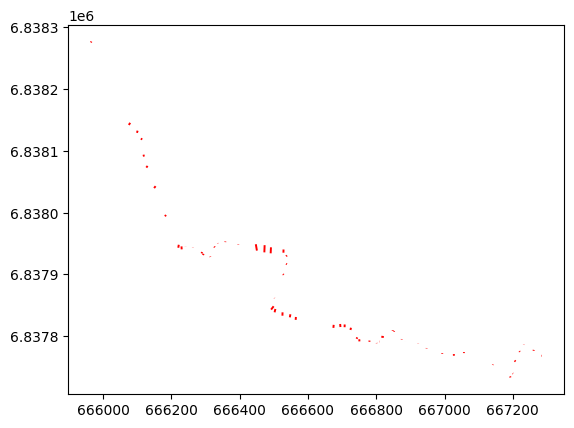

In [43]:
si = SpatialIndex(network) #, resolution=[5,1], margin=0.15)
network.spatial_index = si

network.prepare()

mapping.mapOnNetwork(trace, network, search_radius=25, debug=False)

In [44]:
out_str3 = '{ '
out_str3 += '    "type": "FeatureCollection", '
out_str3 += '    "features": [ '

for k in range(len(trace)):
    X = [trace[k].position.getX(), trace["hmm_inference", k][0].getX()]
    Y = [trace[k].position.getY(), trace["hmm_inference", k][0].getY()]
    print (X)
    #plt.plot(X, Y, "r--", linewidth=1.4)
    #track[k].position.setX(track["hmm_inference", k][0].getX())
    #track[k].position.setY(track["hmm_inference", k][0].getY())
    
    
out_str3 += '    ]'
out_str3 += '}'
#print(type(out_str), out_str)
# out3 = json.loads(out_str3)

[665964.0001256733, 665964.0001256733]
[666075.0909209582, 666075.0909209582]
[666098.9780633544, 666098.9780633544]
[666110.100211772, 666110.100211772]
[666116.1180441529, 666116.1180441529]
[666126.3964255877, 666126.3964255877]
[666149.128330408, 666149.128330408]
[666181.0628326465, 666181.0628326465]
[666219.99997139, 666219.99997139]
[666229.4601136271, 666229.4601136271]
[666241.2356459254, 666241.2356459254]
[666262.8216119152, 666262.8216119152]
[666288.3358126767, 666288.3358126767]
[666292.5596929644, 666292.5596929644]
[666313.4093550481, 666313.4093550481]
[666325.2128364021, 666325.2128364021]
[666335.7993806831, 666335.7993806831]
[666357.7631602099, 666357.7631602099]
[666395.8060576558, 666395.8060576558]
[666450.400356304, 666450.400356304]
[666472.1023200173, 666472.1023200173]
[666490.700202033, 666490.700202033]
[666528.106919353, 666528.106919353]
[666536.0223447819, 666536.0223447819]
[666535.8366232035, 666535.8366232035]
[666526.8586984356, 666526.8586984356]


In [45]:
import os
import folium

# stamenterrain
map_mm = folium.Map(location=[y, x], tiles= '', zoom_start=15 )


folium.GeoJson(out,
               control = False,
               marker = folium.CircleMarker(radius = 4, # Radius in metres
                                            weight = 0, #outline weight
                                            fill_color = '#FF0000', 
                                            fill_opacity = 1)).add_to(map_mm)

roads_style_function = lambda x: {
  'color' :  'blue',
  'weight' : 2,
}
folium.GeoJson(out2, style_function=roads_style_function).add_to(map_mm)

map_mm
